<a href="https://colab.research.google.com/github/rajdeepbanerjee-git/JNCLectures_Intro_to_ML/blob/main/Week10/Lec10_grad_boost_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [5]:
data = pd.read_csv("Hitters.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    object 
dtypes: float64

In [6]:
data.drop(["League","Division","NewLeague"], axis = 1, inplace = True)
data.dropna(how = "any", inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AtBat    263 non-null    int64  
 1   Hits     263 non-null    int64  
 2   HmRun    263 non-null    int64  
 3   Runs     263 non-null    int64  
 4   RBI      263 non-null    int64  
 5   Walks    263 non-null    int64  
 6   Years    263 non-null    int64  
 7   CAtBat   263 non-null    int64  
 8   CHits    263 non-null    int64  
 9   CHmRun   263 non-null    int64  
 10  CRuns    263 non-null    int64  
 11  CRBI     263 non-null    int64  
 12  CWalks   263 non-null    int64  
 13  PutOuts  263 non-null    int64  
 14  Assists  263 non-null    int64  
 15  Errors   263 non-null    int64  
 16  Salary   263 non-null    float64
dtypes: float64(1), int64(16)
memory usage: 37.0 KB


In [8]:
X = data.drop(["Salary"], axis = 1)
y = data["Salary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

- Create base model
- initial pred is the pred of base model
for M estimators
- calculate residual using prediction of previous tree
- fit new tree on the residual
- repeat <br>
Final pred = Init pred + eta*pred1 + eta*pred2 + ... + eta*predM

In [9]:
def calculate_loss(y, y_pred):
    loss = (1/len(y)) * 0.5 * np.sum(np.square(y-y_pred))
    return loss

def calculate_residuals(y, y_pred):
    grad = -(y-y_pred)
    return grad

In [10]:
# fit basic regression tree with depth 1
base_tree = DecisionTreeRegressor(max_depth=2, random_state=0)
base_tree.fit(X_train, y_train)
y_pred = base_tree.predict(X_train)

# metrics
calculate_loss(y = y_train, y_pred = y_pred)

34760.98359795453

In [39]:
def train_gbtree(X, y, base_tree, n_tree, eta = 0.01):

  # initialize
  init_pred = base_tree.predict(X) # on training data
  #init_pred = np.mean(y)
  save_trees = []
  residuals = []
  predictions = []

  y_pred = init_pred
  final_pred = init_pred

  # get grad boosted trees
  for m in range(n_tree):
    residual_ = calculate_residuals(y = y, y_pred = y_pred)
    tree = DecisionTreeRegressor(max_depth=2, random_state=0)
    tree.fit(X, residual_)
    y_pred = tree.predict(X)
    final_pred -= eta*y_pred # learning rate*prediction on residual

    # save
    save_trees.append(tree)
    residuals.append(residual_)
    predictions.append(y_pred)

  return save_trees, residuals, predictions, final_pred

In [45]:
loss = []
for n_tree in np.arange(1, 6, 2):
  trained_trees, _ , _ , final_pred =  train_gbtree(X = X_train,
                                                  y = y_train,
                                                  base_tree = base_tree,
                                                  n_tree = n_tree,
                                                  eta = 0.005)
  loss.append(calculate_loss(y = y_train, y_pred = final_pred))


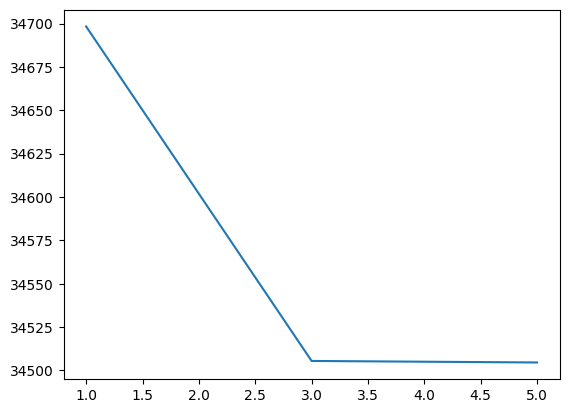

In [47]:
plt.plot(np.arange(1, 6, 2), loss)


In [51]:
def test_predict(n_tree, X, y, trained_trees, base_tree, eta = 0.01):

  init_test_pred = base_tree.predict(X) # on test data
  #init_test_pred = np.mean(y)
  residuals_test = []
  predictions_test = []

  y_test_pred = init_test_pred
  final_pred = init_test_pred
  for m in range(n_tree):
    residual_ = calculate_residuals(y = y, y_pred = y_test_pred)
    y_test_pred = trained_trees[m].predict(X)
    final_pred -= eta*y_test_pred

    # save
    residuals_test.append(residual_)
    predictions_test.append(y_test_pred)

  return final_pred

In [52]:
test_pred =  test_predict(n_tree = 3,
                          X = X_test,
                          y = y_test,
                          trained_trees = trained_trees,
                          base_tree = base_tree)

In [53]:
calculate_loss(y = y_test, y_pred = test_pred)

85738.46525194129

In [54]:
y_pred = base_tree.predict(X_test)
calculate_loss(y = y_test, y_pred = y_pred)

84039.7754255088

#### sklearn grad boost

In [55]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(n_estimators=3, criterion='friedman_mse', max_depth=2)
model.fit(X_train, y_train)
y_sk_pred = model.predict(X_test)
calculate_loss(y = y_test, y_pred = y_sk_pred)

98621.86349212748